<a href="https://colab.research.google.com/github/berndheidemann/notebooks_fastai/blob/master/earthquake/earthquake_mixed_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.imports import *
from fastai.tabular  import *
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Tabular Data

In [0]:
!wget https://github.com/berndheidemann/datasets/raw/master/earthquake_features.zip
!unzip  earthquake_features.zip

--2019-04-25 07:04:01--  https://github.com/berndheidemann/datasets/raw/master/earthquake_features.zip
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/berndheidemann/datasets/master/earthquake_features.zip [following]
--2019-04-25 07:04:02--  https://raw.githubusercontent.com/berndheidemann/datasets/master/earthquake_features.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5848057 (5.6M) [application/zip]
Saving to: ‘earthquake_features.zip.1’

earthquake_features 100%[===================>]   5.58M  --.-KB/s    in 0.1s    

2019-04-25 07:04:02 (49.5 MB/s) - ‘earthquake_feature

In [0]:
df_train=pd.read_csv("new_train_x_unscaled.csv")
df_train=df_train.drop("Unnamed: 0", axis=1)
df_y=pd.read_csv("new_train_y.csv")

In [0]:
means_dict = {}
for col in df_train.columns:
    if df_train[col].isnull().any():
        print(col)
        mean_value = df_train.loc[df_train[col] != -np.inf, col].mean()
        df_train.loc[df_train[col] == -np.inf, col] = mean_value
        df_train[col] = df_train[col].fillna(mean_value)
        means_dict[col] = mean_value

classic_sta_lta5_mean
classic_sta_lta7_mean


In [0]:
scaler = StandardScaler()
scaler.fit(df_train)
df_train = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns)

In [0]:
procs=[Normalize, FillMissing]

In [0]:
df_test=pd.read_csv("new_test_x.csv")


In [0]:
seq_series=df_test.seg_id
df_test=df_test.drop("seg_id", axis=1)
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)


In [0]:
test = TabularList.from_df(df_test, cont_names=df_test.columns, cat_names=[], procs=procs)

In [0]:
df_train["target"]=df_y["time_to_failure"]

In [0]:
df_train["target"]=df_train["target"].fillna(df_train["target"].mean()) #unsauber

In [0]:
valid_idx=range(len(df_train)-len(df_train)//10, len(df_train)-1)

In [0]:
tab_data=(TabularList.from_df(df_train, cont_names=df_train.drop("target", axis=1).columns.values, cat_names=[], procs=procs)
      .split_by_idx(valid_idx)
      .label_from_df(cols="target", label_cls=FloatList)
      .add_test(test)
      .databunch())

In [0]:
tab_learn=tabular_learner(tab_data, layers=[200, 100], metrics=mean_absolute_error, wd=0.1)

In [0]:
tab_learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,33.484623,8.185775,2.118918,00:00
1,13.818708,4.685052,1.684292,00:00
2,9.226564,6.987630,1.986137,00:00
3,7.909366,6.385291,1.934030,00:00
4,7.289331,6.798488,2.004807,00:00


# Images

In [0]:
from fastai.vision import *

In [0]:
!gdown  https://drive.google.com/uc?id=1UwcWco71QfpSGYXfPR11DeRsP0EeZJbw

Downloading...
From: https://drive.google.com/uc?id=1UwcWco71QfpSGYXfPR11DeRsP0EeZJbw
To: /content/Earthquake_images.zip
152MB [00:01, 93.9MB/s]


In [0]:
!mkdir images
!unzip Earthquake_images.zip -d images

Archive:  Earthquake_images.zip
  inflating: images/435.jpg          
  inflating: images/436.jpg          
  inflating: images/437.jpg          
  inflating: images/438.jpg          
  inflating: images/439.jpg          
  inflating: images/440.jpg          
  inflating: images/441.jpg          
  inflating: images/442.jpg          
  inflating: images/443.jpg          
  inflating: images/444.jpg          
  inflating: images/445.jpg          
  inflating: images/446.jpg          
  inflating: images/447.jpg          
  inflating: images/448.jpg          
  inflating: images/449.jpg          
  inflating: images/450.jpg          
  inflating: images/451.jpg          
  inflating: images/452.jpg          
  inflating: images/453.jpg          
  inflating: images/454.jpg          
  inflating: images/455.jpg          
  inflating: images/456.jpg          
  inflating: images/457.jpg          
  inflating: images/458.jpg          
  inflating: images/459.jpg          
  inflating: image

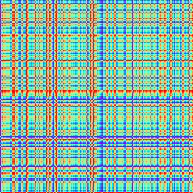

In [0]:
open_image("images/997.jpg")

In [0]:
path="./images"
fnames = get_image_files(path)
def get_target(fname):
  return df_y["time_to_failure"].iloc[int(fname.name.split(".")[0])].astype("float")

In [0]:
img_data=(ImageList.from_folder(path)
            .split_by_idx(valid_idx)
            .label_from_func(get_target, label_cls=FloatList)
            .databunch(bs=16))

In [0]:
img_learn = cnn_learner(img_data, models.resnet34, metrics=mean_absolute_error)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 94465454.74it/s]


In [0]:
img_learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,15.108904,14.880770,3.161187,00:16
1,12.691208,14.424759,3.133535,00:15


# Mix It

In [0]:
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, y): self.x1,self.x2,self.y = x1,x2,y
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return (self.x1[i], self.x2[i]), self.y[i]

train_ds = ConcatDataset(tab_data.train_ds.x, img_data.train_ds.x, tab_data.train_ds.y)
valid_ds = ConcatDataset(tab_data.valid_ds.x, img_data.valid_ds.x, tab_data.valid_ds.y)

In [0]:
bs=32
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)
data = DataBunch(train_dl, valid_dl, device=defaults.device)

In [0]:
(x1,x2),y = next(iter(data.train_dl))
print(f'Shape tabular batch (cats/cont): {x1[0].shape} / {x1[1].shape}')
print(f'Shape image batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape tabular batch (cats/cont): torch.Size([32]) / torch.Size([32, 138])
Shape image batch: torch.Size([32, 3, 193, 193])
Shape dependent var: torch.Size([32])


In [0]:
class ConcatModel(nn.Module):
    def __init__(self, mod_tab, mod_img): 
        super().__init__()
        self.mod_tab = mod_tab
        self.mod_img = mod_img
        
        self.layers = nn.Sequential(
            nn.BatchNorm1d(2),
            nn.Linear(2, 10),
            torch.nn.ReLU(inplace=True),
            nn.BatchNorm1d(10),
            nn.Linear(10, 1)
        )


    def forward(self, *x):
        x_tab = self.mod_tab(*x[0])
        x_mod = self.mod_img(x[1])
        x = torch.cat([x_tab, x_mod], dim=1)
        return self.layers(x)

In [0]:
model = ConcatModel(tab_learn.model, img_learn.model)

In [0]:
len(tab_learn.layer_groups)

1

In [0]:
layer_groups = [nn.Sequential(*flatten_model(img_learn.layer_groups[0])),
                nn.Sequential(*flatten_model(img_learn.layer_groups[1])),
                nn.Sequential(*flatten_model(tab_learn.layer_groups[0])),
                nn.Sequential(*flatten_model(img_learn.layer_groups[2])),
                nn.Sequential(*flatten_model(model.layers))] 
                                

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


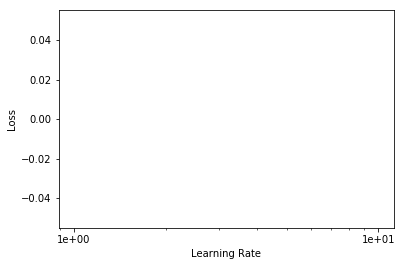

In [0]:
learn = Learner(data, model, loss_func=nn.MSELoss(reduce=True), metrics=mean_absolute_error)
gc.collect()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.freeze()

AssertionError: ignored

In [0]:
learn.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,19.989321,91.332047,4.722886,00:20


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


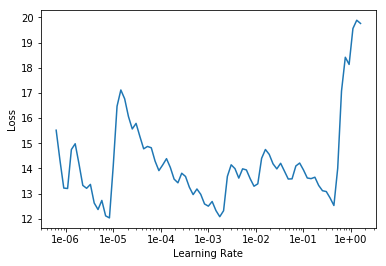

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=1e-4)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,13.574656,11.903486,3.036383,00:20
1,13.576846,11.872352,3.031893,00:21
2,13.574465,11.855320,3.029406,00:20
3,13.570532,11.851537,3.028854,00:20
4,13.567908,11.851427,3.028851,00:21


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


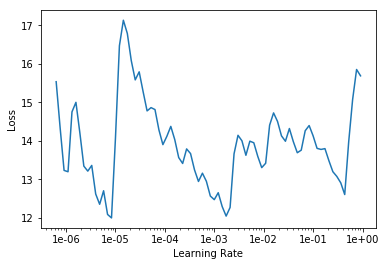

In [0]:
learn.save("stage-1")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(5e-5, 1e-3))

epoch,train_loss,valid_loss,mean_absolute_error,time
0,13.596095,11.704911,3.007378,00:26
1,13.626548,11.509696,2.977048,00:26
2,13.619670,11.472190,2.971116,00:26
3,13.595074,11.501595,2.975801,00:26
4,13.576738,11.514577,2.977838,00:26


# try different  archs

In [0]:
np.random.seed(42)
neurons = range(50, 1000, 50)
max_layers = 6
archs=[]
for i in range(100):
  layers=np.random.randint(2, max_layers)
  a=[]
  for j in range(layers):
    a.append(neurons[np.random.randint(len(neurons))])
  archs.append(a)

In [0]:
losses=[]
for arch in archs:''
  learn=tabular_learner(data, layers=arch, metrics=mean_absolute_error)''
  learn.fit_one_cycle(5, 1e-2)
  learn.fit_one_cycle(5, 1e-5)
  losses.append(learn.validate())

In [0]:
loss_dic= dict()
for i, l in enumerate(losses):
  loss_dic[str(archs[i])]=l[1].item()
loss_dic = sorted(loss_dic.items(), key=lambda kv: kv[1]); loss_dic[:5]

[('[100, 150, 800]', 2.167044162750244),
 ('[300, 200, 550]', 2.1726009845733643),
 ('[550, 800, 800]', 2.173501968383789),
 ('[200, 400, 150, 100, 600]', 2.1737112998962402),
 ('[950, 100, 500, 650]', 2.1751747131347656)]

# Normal Learner

In [0]:
#[100, 150, 800]
learn=tabular_learner(data, layers=[200, 100], metrics=mean_absolute_error, wd=0.1)

In [0]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,32.127853,5.449506,1.701243,00:00
1,13.428855,6.104516,1.925780,00:00
2,9.083377,5.187352,1.811614,00:00
3,7.755704,6.506332,2.024782,00:00
4,7.380338,5.980947,1.926100,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


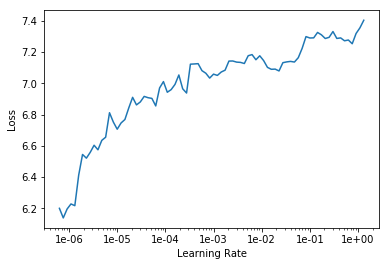

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.save("stage-1")

In [0]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,7.047713,6.259535,1.971915,00:00
1,7.093653,6.785993,2.025832,00:00
2,7.069152,7.042556,2.081981,00:00
3,7.021644,6.443924,1.972273,00:00
4,6.905973,6.608084,1.997942,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


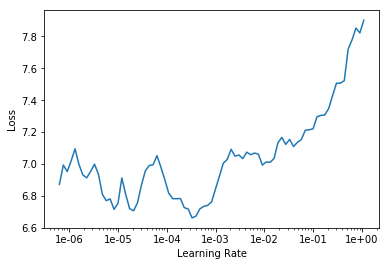

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, 1e-4, pct_start=0.8)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,7.140427,6.727303,2.039706,00:00
1,6.928569,6.876080,2.049930,00:00
2,6.970058,7.009948,2.068052,00:00
3,7.036692,7.432436,2.134101,00:00
4,7.119581,6.726747,2.025914,00:00
5,7.083479,6.918650,2.056630,00:00
6,7.051063,7.465295,2.139242,00:00
7,7.216074,7.669672,2.140560,00:00
8,7.064061,7.498982,2.145152,00:00
9,7.071121,7.309853,2.123401,00:00


In [0]:
learn.save("2.29")

# Submission

In [0]:
preds, _ = learn.get_preds(DatasetType.Test)

In [0]:
preds=list(map(lambda x: x.item(), preds))

In [0]:
res_df = pd.DataFrame({'seg_id': seq_series, 'time_to_failure': preds})
res_df.to_csv('submission_2.29.csv', index=False)

In [0]:
!cat submission_2.29.csv | head -4

seg_id,time_to_failure
seg_00030f,3.4503557682037354
seg_0012b5,6.034409523010254
seg_00184e,6.070537567138672


# Feature Importance

In [0]:
def feature_importance(learner, cat_names, cont_names): 
  # based on: https://medium.com/@mp.music93/neural-networks-feature-importance-with-fastai-5c393cf65815
  loss0=np.array([learn.loss_func(learn.pred_batch(batch=(x,y.to("cpu"))), y.to("cpu")) for x,y in iter(learner.data.valid_dl)]).mean(); loss0
  fi=dict()
  types=[cat_names, cont_names]
  for j, t in enumerate(types):
    for i, c in enumerate(t):
      loss=[]
      for x,y in iter(learner.data.valid_dl):
        col=x[j][:,i]    
        idx = torch.randperm(col.nelement())
        x[j][:,i] = col.view(-1)[idx].view(col.size())
        y=y.to('cpu')
        loss.append(learn.loss_func(learn.pred_batch(batch=(x,y)), y))
      fi[c]=np.array(loss).mean()-loss0
  d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
  return pd.DataFrame({'cols': [l for l, v in d], 'imp': np.log1p([v for l, v in d])})

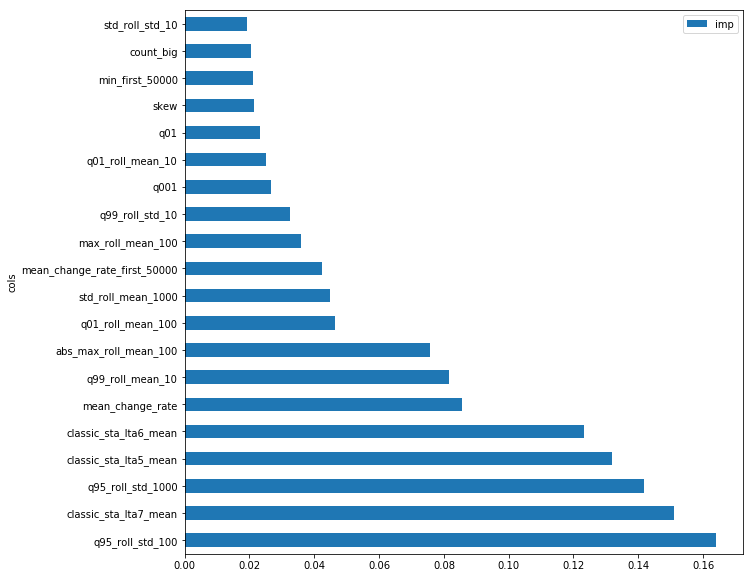

In [0]:
fi = feature_importance(learn, [], df_train.drop("target", axis=1).columns)
fi[:20].plot.barh(x="cols", y="imp", figsize=(10, 10))

In [0]:
def partial_dependence(learn, df, feature):
  pdi=dict()
  steps=30
  ci=learn.data.col_names.index(feature)
  if learn.data.get(0).classes!=None:
    is_cat= feature in learn.data.get(0).classes
  else:
    is_cat=False
  if is_cat: 
    vals=learn.data.get(0).classes[feature] 
    j=0
  else: 
    j=1
    vals= np.linspace(df_train[feature].min(), df_train[feature].max(), num=steps)
    if vals[-1]-vals[0]>steps:
      vals=np.floor(vals).astype("int")
    if learn.data.get(0).classes!=None:
      ci-=len(learn.data.get(0).classes)
    mean=df[feature].mean()
    std=df[feature].std()
  baseY=np.array([learn.pred_batch(batch=(x,y.to("cpu"))).mean() for x,y in iter(learn.data.valid_dl)]).mean()
  for i, val in enumerate(vals):
    ys=[]
    for x,y in iter(learn.data.valid_dl):
      x[j][:,ci] = torch.full((x[j][:,ci].shape), i if is_cat else (val-mean)/(1e-7+std))
      y=y.to('cpu')
      ys.append(np.array(learn.pred_batch(batch=(x,y))).mean())
    pdi[val]=np.array(ys).mean()-baseY
  if is_cat:
    d = sorted(pdi.items(), key=lambda kv: kv[1], reverse=True)
  else:
    d=list(pdi.items())
  return pd.DataFrame({'vals': [k for k, v in d], 'diff': [v for k, v in d]})

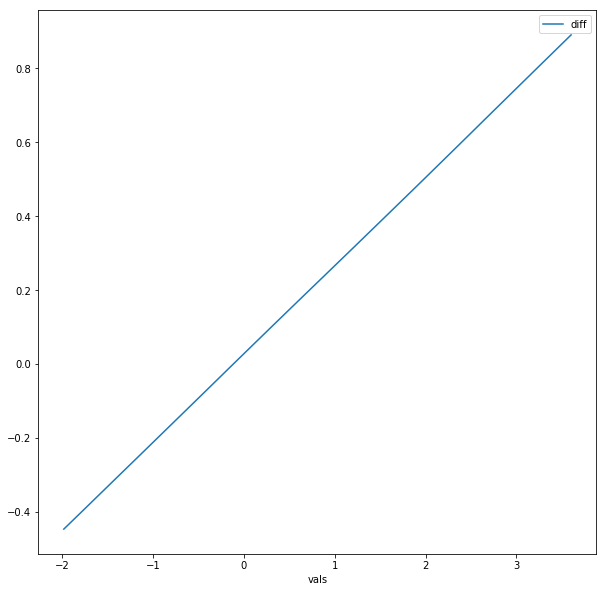

In [0]:
pdi=partial_dependence(learn, df_train, "classic_sta_lta5_mean")
pdi.plot.line(x="vals", y="diff", figsize=(10, 10))

In [0]:
learn.data.get(0).classes